<a href="https://colab.research.google.com/github/sudhansh296/crack-detection/blob/main/Crack_Detection_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import plotly.express as px

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, r2_score

import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
positive_dir = Path(r'/content/drive/MyDrive/Positive')
negative_dir = Path(r'/content/drive/MyDrive/Negative')

In [4]:
def generate_df(img_dir, label):

    file_paths = pd.Series(list(img_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=file_paths.index)
    df = pd.concat([file_paths, labels], axis=1)

    return df

In [5]:
positive_df = generate_df(positive_dir, 'POSITIVE')
negative_df = generate_df(negative_dir, 'NEGATIVE')

all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1, random_state=1).reset_index(drop=True)
print(all_df)

                                       Filepath     Label
0     /content/drive/MyDrive/Negative/00132.jpg  NEGATIVE
1     /content/drive/MyDrive/Positive/00350.jpg  POSITIVE
2     /content/drive/MyDrive/Negative/00192.jpg  NEGATIVE
3     /content/drive/MyDrive/Positive/00466.jpg  POSITIVE
4     /content/drive/MyDrive/Positive/00290.jpg  POSITIVE
...                                         ...       ...
1178  /content/drive/MyDrive/Negative/00105.jpg  NEGATIVE
1179  /content/drive/MyDrive/Negative/00263.jpg  NEGATIVE
1180  /content/drive/MyDrive/Negative/00485.jpg  NEGATIVE
1181  /content/drive/MyDrive/Positive/00260.jpg  POSITIVE
1182  /content/drive/MyDrive/Negative/00435.jpg  NEGATIVE

[1183 rows x 2 columns]


In [6]:
train_df, test_df = train_test_split(all_df.sample(1000, random_state=1),
                train_size=0.7,
                shuffle=True,
                random_state=1)

In [7]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                           validation_split=0.2)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [8]:
train_data = train_gen.flow_from_dataframe(train_df,
                                          x_col='Filepath',
                                          y_col='Label',
                                          target_size=(120,120),
                                          color_mode='rgb',
                                          class_mode='binary',
                                          batch_size=32,
                                          shuffle=True,
                                          seed=42,
                                          subset='training')


val_data = train_gen.flow_from_dataframe(train_df,
                                          x_col='Filepath',
                                          y_col='Label',
                                          target_size=(120,120),
                                          color_mode='rgb',
                                          class_mode='binary',
                                          batch_size=32,
                                          shuffle=True,
                                          seed=42,
                                          subset='validation')


test_data = test_gen.flow_from_dataframe(test_df,
                                          x_col='Filepath',
                                          y_col='Label',
                                          target_size=(120,120),
                                          color_mode='rgb',
                                          class_mode='binary',
                                          batch_size=32,
                                          shuffle=False,
                                          seed=42)

Found 560 validated image filenames belonging to 2 classes.
Found 140 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.


In [9]:
test_data

In [10]:
inputs = tf.keras.Input(shape=(120,120,3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

In [11]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [12]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [13]:
# print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 120, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 118, 118, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 57, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,121 (20.00 KB)

 Trainable params: 5,121 (20.00 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(train_data, validation_data=val_data, epochs=100,
                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                              patience=3,
                                                              restore_best_weights=True)
                             ])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 86s 5s/step - accuracy: 0.5093 - loss: 0.6907 - val_accuracy: 0.7286 - val_loss: 0.6830
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 484ms/step - accuracy: 0.5904 - loss: 0.6803 - val_accuracy: 0.6571 - val_loss: 0.6728
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 369ms/step - accuracy: 0.5538 - loss: 0.6656 - val_accuracy: 0.8714 - val_loss: 0.6609
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 483ms/step - accuracy: 0.6114 - loss: 0.6678 - val_accuracy: 0.6143 - val_loss: 0.6514
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 401ms/step - accuracy: 0.7100 - loss: 0.6492 - val_accuracy: 0.4929 - val_loss: 0.6509
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 371ms/step - accuracy: 0.6981 - loss: 0.6207 - val_accuracy: 0.8786 - val_loss: 0.6046
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 487ms/step - accuracy: 0.7561 - loss: 0.6105 - val_accuracy: 0.8714 - val_loss: 0.5723
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 381ms/step - accuracy: 0.7886 - loss: 0.5775 - val_accur

### PLLOTING

In [15]:
fig = px.line(history.history,
             y=['loss', 'val_loss'],
             labels={'index':'Epoch'},
             title='Training and Validation Loss over Time')

fig.show()

### **FINAL RESULT**

### **TESTING NEW DATASET**

In [16]:
def test_new_data(dir_path):

    new_test_dir = Path(dir_path)

    df_new = generate_df(new_test_dir, 'Testing')

    test_data_new = test_gen.flow_from_dataframe(df_new,
                                          x_col='Filepath',
                                          y_col='Label',
                                          target_size=(120,120),
                                          color_mode='rgb',
                                          batch_size=5,
                                          shuffle=False,
                                          seed=42)

    # predicted y values
    y_pred = np.squeeze((model.predict(test_data_new) >= 0.5).astype(int))


    y_certain = model.predict(test_data_new).round(6)
    y_out = []
    for i in y_pred:
        if i==0:
            y_out.append('Negative (Not Crack)')
        else:
            y_out.append('Positive(Crack) ')

    result = pd.DataFrame(np.c_[y_out, y_certain], columns=['Result', 'Confidance of being Cracked'])

    return result

In [17]:
import matplotlib.pyplot as plt
import random
import cv2
import numpy as np
import os

0.082205996
actual:  Negative predicted:  negative


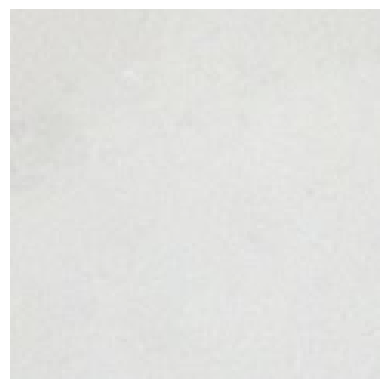

In [20]:
def func(path,model):
  y_true=random.choice(os.listdir(path))
  folder_path=os.path.join(path,y_true)
  file_path=os.path.join(folder_path,random.choice(os.listdir(folder_path)))
  img=cv2.imread(file_path)
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img=cv2.resize(img,(120,120))
  img_scalled=img.astype("float32")
  img_scalled=img_scalled/255.
  img_scalled=np.expand_dims(img_scalled,axis=0)
  predicted=model.predict(img_scalled,verbose=0)
  print(predicted[0][0])
  if predicted[0][0]<0.5:
    y_pred="negative"
  else:
    y_pred="positive"
  print("actual: ",y_true,"predicted: ",y_pred)
  plt.imshow(img)
  plt.axis("off")
  plt.show
func("/content/drive/MyDrive/surface-crack-detection",model)